In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [5]:
np.random.seed(42)
tf.random.set_seed(42)
base_path = r"C:\Users\Rachit Patel\Desktop\Mediscan.Tech\kagglehub\datasets\oral-diseases"
categories = ['Calculus', 'Caries', 'Gingivitis', 'Hypodontia', 'Mouth Ulcer', 'Tooth Discoloration']

In [6]:
def load_and_preprocess_data(base_path):
    images = []
    labels = []
    for idx, category in enumerate(categories):
        path = os.path.join(base_path, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224)) 
            img = img / 255.0  # Normalize
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)

In [7]:
X, y = load_and_preprocess_data(base_path)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
num_classes = len(categories)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [11]:
datagen.fit(X_train)

In [12]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [13]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
checkpoint = ModelCheckpoint('oral_disease_model.keras', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [17]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, reduce_lr, early_stopping])

c:\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 64s 473ms/step - accuracy: 0.4618 - loss: 1.4408 - val_accuracy: 0.6348 - val_loss: 0.8417 - learning_rate: 0.0010
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 450ms/step - accuracy: 0.6397 - loss: 0.8980 - val_accuracy: 0.6866 - val_loss: 0.7495 - learning_rate: 0.0010
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 453ms/step - accuracy: 0.6565 - loss: 0.8314 - val_accuracy: 0.6844 - val_loss: 0.6993 - learning_rate: 0.0010
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 58s 440ms/step - accuracy: 0.6739 - loss: 0.7833 - val_accuracy: 0.6995 - val_loss: 0.6804 - learning_rate: 0.0010
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 438ms/step - accuracy: 0.6937 - loss: 0.7371 - val_accuracy: 0.7160 - val_loss: 0.6734 - learning_rate: 0.0010
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - accuracy: 0.7082 - loss: 0.6902 - val_accuracy: 0.7441 - val_loss: 0.6237 - learning_rate: 0.0010
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 58s 447ms/step - accura

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.8026 - loss: 0.4898
Test accuracy: 0.8073


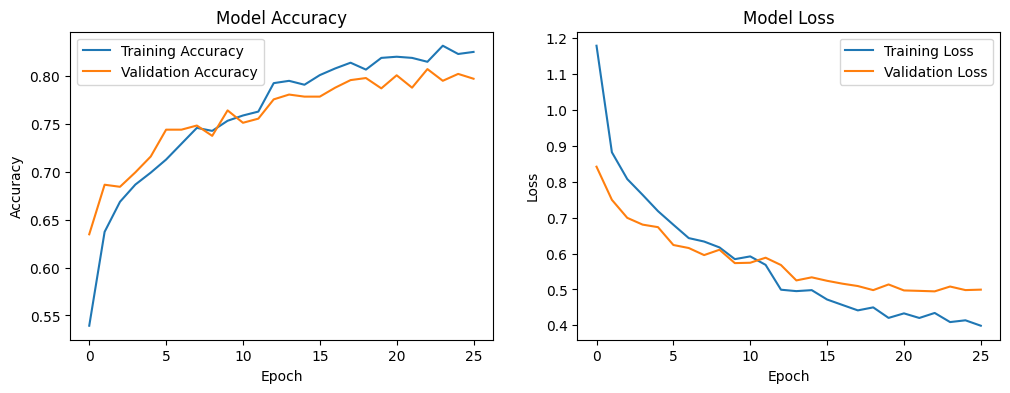

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step


In [21]:
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

                     precision    recall  f1-score   support

           Calculus       0.75      0.58      0.65       350
             Caries       0.87      0.43      0.57        61
         Gingivitis       0.76      0.90      0.82       580
         Hypodontia       0.95      0.96      0.96       296
        Mouth Ulcer       0.91      0.95      0.93        61
Tooth Discoloration       0.87      0.63      0.73        43

           accuracy                           0.81      1391
          macro avg       0.85      0.74      0.78      1391
       weighted avg       0.81      0.81      0.80      1391



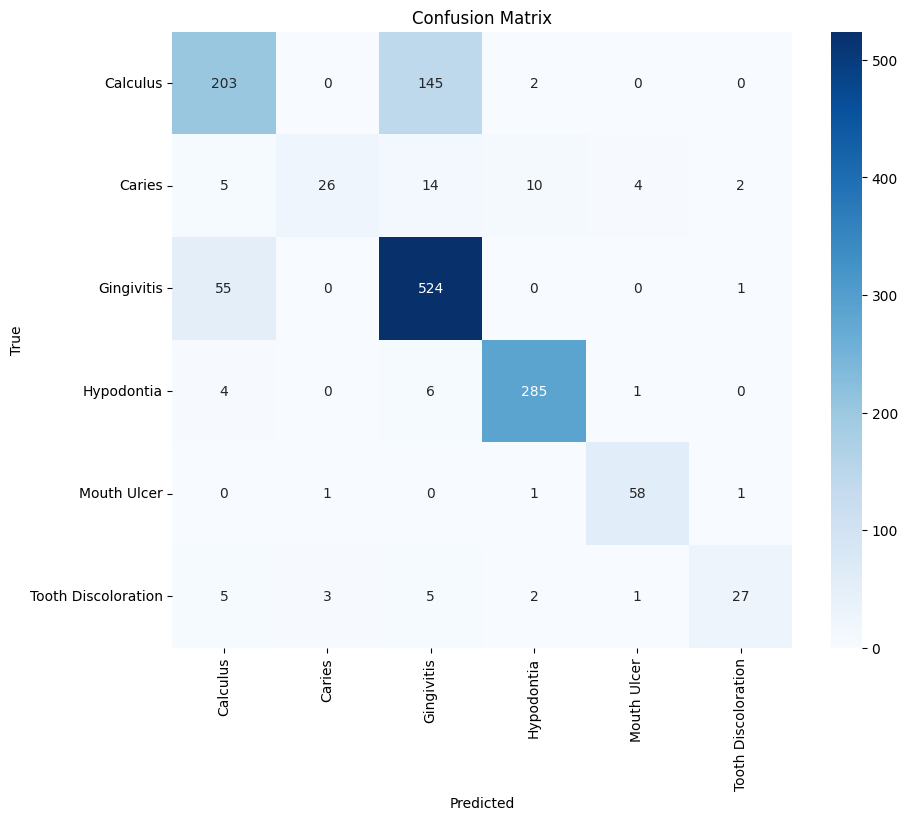

In [22]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
model.save(r"C:\Users\Rachit Patel\Desktop\Mediscan.Tech\model-api\oral_diseases_model.h5")